In [1]:
# Apriori alg. implementation
from collections import Counter

def frequentItems(transactions, support):
    counter = Counter()
    for trans in transactions:
        counter.update(frozenset([t]) for t in trans)
    return set(item for item in counter if counter[item]/len(transactions) >= support), counter

def generateCandidates(L, k):
    candidates = set()
    for a in L:
        for b in L:
            union = a | b
            if len(union) == k and a != b:
                candidates.add(union)
    return candidates

def filterCandidates(transactions, itemsets, support):
    counter = Counter()
    for trans in transactions:
        subsets = [itemset for itemset in itemsets if itemset.issubset(trans)]
        counter.update(subsets)
    return set(item for item in counter if counter[item]/len(transactions) >= support), counter

def apriori(transactions, support):
    result = list()
    resultc = Counter()
    candidates, counter = frequentItems(transactions, support)
    result += candidates
    resultc += counter
    k = 2
    while candidates:
        candidates = generateCandidates(candidates, k)
        candidates,counter = filterCandidates(transactions, candidates, support)
        result += candidates
        resultc += counter
        k += 1
    resultc = {item:(resultc[item]/len(transactions)) for item in resultc}
    return result, resultc

In [2]:
import pandas as pd
from pprint import pprint

import itertools 
def getSubsets(itemset):
    itemlist = list()
    for n in range(1,len(itemset)+1):
        itemlist.extend(map(frozenset,itertools.combinations(itemset, n)))
    return itemlist

def generateRules(frequentItemsets, supports, minConfidence, metric='confidence', sort=''):
    rules = []
    for itemset in frequentItemsets:
        subsets = getSubsets(itemset)
        for subset in subsets:
            X = itemset-subset
            Y = subset
            metricValue = 0
            if X == frozenset():
                continue
            if metric == 'confidence':
                metricValue = supports[X|Y]/supports[Y]
            if metric == 'lift':
                metricValue = supports[X|Y]/(supports[X]*supports[Y])
            if metric == 'conviction':
                confidence = supports[X|Y]/supports[Y]
                if 1-confidence != 0:
                    metricValue = (1-supports[Y])/(1-supports[X|Y]/supports[Y])
            if metricValue >= minConfidence:
                rules.append(((itemset-subset,subset), metricValue, supports[subset]))
    if sort == 'asc':
        return sorted(rules, key=lambda x: x[1])
    if sort == 'desc':
        return sorted(rules, key=lambda x: x[1], reverse=True)
    return rules

In [3]:
df = pd.read_csv('./bank-data.csv')
del df["id"]
df["income"] = pd.cut(df["income"],10)
dataset = []
for index, row in df.iterrows():
    row = [col+"="+str(row[col]) for col in list(df)]
    dataset.append(row)

## Confidence

In [4]:
metric = 'confidence'
frequentItemsets, supports = apriori(dataset, 0.3)
rules = generateRules(frequentItemsets, supports, 0.5, metric, 'desc')
for rule in rules:
    rule, metricValue, support = rule
    antecedent, consequent = list(rule)
    print("{} => {}, metric: {}, metricValue: {:.2f}, support: {}".format(antecedent, consequent, metric, metricValue, support))


frozenset({'current_act=YES'}) => frozenset({'mortgage=NO', 'save_act=YES'}), metric: confidence, metricValue: 0.79, support: 0.45
frozenset({'current_act=YES'}) => frozenset({'car=NO'}), metric: confidence, metricValue: 0.77, support: 0.5066666666666667
frozenset({'current_act=YES'}) => frozenset({'save_act=YES'}), metric: confidence, metricValue: 0.77, support: 0.69
frozenset({'current_act=YES'}) => frozenset({'pep=YES'}), metric: confidence, metricValue: 0.77, support: 0.45666666666666667
frozenset({'current_act=YES'}) => frozenset({'mortgage=NO'}), metric: confidence, metricValue: 0.77, support: 0.6516666666666666
frozenset({'current_act=YES'}) => frozenset({'sex=FEMALE'}), metric: confidence, metricValue: 0.77, support: 0.5
frozenset({'current_act=YES'}) => frozenset({'mortgage=NO', 'married=YES'}), metric: confidence, metricValue: 0.76, support: 0.435
frozenset({'current_act=YES'}) => frozenset({'region=INNER_CITY'}), metric: confidence, metricValue: 0.76, support: 0.448333333333

## Lift

In [5]:
metric = 'lift'
frequentItemsets, supports = apriori(dataset, 0.3)
rules = generateRules(frequentItemsets, supports, 0.5, metric, 'desc')
for rule in rules:
    rule, metricValue, support = rule
    antecedent, consequent = list(rule)
    print("{} => {}, metric: {}, metricValue: {:.2f}, support: {}".format(antecedent, consequent, metric, metricValue, support))


frozenset({'married=YES'}) => frozenset({'pep=NO'}), metric: lift, metricValue: 1.12, support: 0.5433333333333333
frozenset({'pep=NO'}) => frozenset({'married=YES'}), metric: lift, metricValue: 1.12, support: 0.66
frozenset({'mortgage=NO'}) => frozenset({'sex=FEMALE'}), metric: lift, metricValue: 1.05, support: 0.5
frozenset({'sex=FEMALE'}) => frozenset({'mortgage=NO'}), metric: lift, metricValue: 1.05, support: 0.6516666666666666
frozenset({'save_act=YES'}) => frozenset({'pep=NO'}), metric: lift, metricValue: 1.04, support: 0.5433333333333333
frozenset({'pep=NO'}) => frozenset({'save_act=YES'}), metric: lift, metricValue: 1.04, support: 0.69
frozenset({'current_act=YES', 'married=YES'}) => frozenset({'mortgage=NO'}), metric: lift, metricValue: 1.04, support: 0.6516666666666666
frozenset({'mortgage=NO'}) => frozenset({'current_act=YES', 'married=YES'}), metric: lift, metricValue: 1.04, support: 0.48833333333333334
frozenset({'married=YES'}) => frozenset({'children=0'}), metric: lift, m

In [6]:
## Conviction

In [7]:
metric = 'conviction'
frequentItemsets, supports = apriori(dataset, 0.3)
rules = generateRules(frequentItemsets, supports, 0.5, metric, 'desc')
for rule in rules:
    rule, metricValue, support = rule
    antecedent, consequent = list(rule)
    print("{} => {}, metric: {}, metricValue: {:.2f}, support: {}".format(antecedent, consequent, metric, metricValue, support))

frozenset({'current_act=YES'}) => frozenset({'mortgage=NO', 'save_act=YES'}), metric: conviction, metricValue: 2.56, support: 0.45
frozenset({'current_act=YES'}) => frozenset({'mortgage=NO', 'married=YES'}), metric: conviction, metricValue: 2.38, support: 0.435
frozenset({'current_act=YES'}) => frozenset({'pep=YES'}), metric: conviction, metricValue: 2.36, support: 0.45666666666666667
frozenset({'current_act=YES'}) => frozenset({'region=INNER_CITY'}), metric: conviction, metricValue: 2.32, support: 0.4483333333333333
frozenset({'current_act=YES'}) => frozenset({'children=0'}), metric: conviction, metricValue: 2.31, support: 0.43833333333333335
frozenset({'current_act=YES'}) => frozenset({'car=NO'}), metric: conviction, metricValue: 2.17, support: 0.5066666666666667
frozenset({'current_act=YES'}) => frozenset({'sex=FEMALE'}), metric: conviction, metricValue: 2.14, support: 0.5
frozenset({'current_act=YES'}) => frozenset({'married=YES', 'save_act=YES'}), metric: conviction, metricValue: 

# Data Analysis

In [8]:
df = pd.read_csv('./Auto.csv')
dataset = []
del df['name']
df['displacement'] = (df['displacement']/100).astype(int)*100
df['acceleration'] = (df['acceleration']/10).astype(int)*10
df['weight'] = (df['weight']/100).astype(int)*100
for index, row in df.iterrows():
    row = [col+"="+str(row[col]) for col in list(df)]
    dataset.append(row)
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,18.0,8,300,130,3500,10,70,1
1,15.0,8,300,165,3600,10,70,1
2,18.0,8,300,150,3400,10,70,1
3,16.0,8,300,150,3400,10,70,1
4,17.0,8,300,140,3400,10,70,1
5,15.0,8,400,198,4300,10,70,1
6,14.0,8,400,220,4300,0,70,1
7,14.0,8,400,215,4300,0,70,1
8,14.0,8,400,225,4400,10,70,1
9,15.0,8,300,190,3800,0,70,1


In [15]:
import numpy as np

rulesAll = {}
x = 0
for a in np.arange(0.1, 0.59,0.05):
    rulesAll[x] = {}
    frequentItemsets, supports = apriori(dataset, a)
    y = 0
    for b in np.arange(0.1, 0.59,0.05):
        rulesAll[x][y] = {}
        rulesAll[x][y]['confidence'] = generateRules(frequentItemsets, supports, b, 'confidence')
        rulesAll[x][y]['lift'] = generateRules(frequentItemsets, supports, b, 'lift')
        rulesAll[x][y]['conviction'] = generateRules(frequentItemsets, supports, b, 'conviction')
        y += 1
    x += 1

In [16]:
size = 10
meanOfMetricValues = {
    'confidence': np.zeros((size,size)),
    'lift': np.zeros((size,size)),
    'conviction': np.zeros((size,size))
}

meanOfSupports = {
    'confidence': np.zeros((size,size)),
    'lift': np.zeros((size,size)),
    'conviction': np.zeros((size,size))
}

for m in meanOfMetricValues:
    for a in rulesAll:
        for b in rulesAll[a]:
            rules = rulesAll[a][b][m]
            count = 0
            _sumOfMetricVaues = 0
            _sumOfSupports = 0
            for rule in rules:
                r, metricValue, support = rule
                _sumOfMetricVaues += metricValue
                _sumOfSupports += support
                count += 1
            if count == 0: continue
            meanOfMetricValues[m][a][b]= _sumOfMetricVaues/count
            meanOfSupports[m][a][b] = _sumOfSupports/count



In [17]:
pprint(meanOfMetricValues)
pprint(meanOfSupports)

{'confidence': array([[0.61814419, 0.62791092, 0.64938604, 0.68636112, 0.74301071,
        0.78158362, 0.79919466, 0.81352474, 0.85051634, 0.87070762],
       [0.65448494, 0.65448494, 0.68191548, 0.71400796, 0.77587769,
        0.83376616, 0.85234747, 0.86587564, 0.88735407, 0.89547233],
       [0.65328104, 0.65328104, 0.65328104, 0.6925237 , 0.73476142,
        0.74816168, 0.77436545, 0.81816674, 0.84903251, 0.88092069],
       [0.68657347, 0.68657347, 0.68657347, 0.68657347, 0.71348056,
        0.73971818, 0.73971818, 0.76428049, 0.78630387, 0.83753449],
       [0.7143193 , 0.7143193 , 0.7143193 , 0.7143193 , 0.7143193 ,
        0.78795239, 0.78795239, 0.78795239, 0.85994049, 0.85994049],
       [0.74630413, 0.74630413, 0.74630413, 0.74630413, 0.74630413,
        0.74630413, 0.74630413, 0.74630413, 0.8284055 , 0.8284055 ],
       [0.74630413, 0.74630413, 0.74630413, 0.74630413, 0.74630413,
        0.74630413, 0.74630413, 0.74630413, 0.8284055 , 0.8284055 ],
       [0.74630413, 0.7463

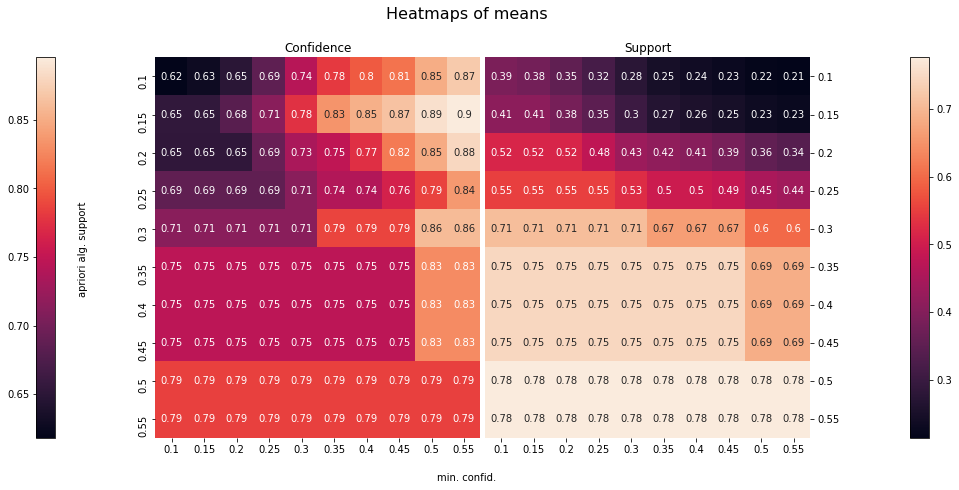

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

ticks = np.around(np.arange(0.1, 0.59,0.05),2)

df =  pd.DataFrame(meanOfMetricValues['confidence'])
df2 = pd.DataFrame(meanOfSupports['confidence'])
fig, (ax,ax2) = plt.subplots(ncols=2)
fig.set_figheight(7)
fig.set_figwidth(18)
fig.suptitle('Heatmaps of means', fontsize=16)
ax.set_title('Confidence')
ax2.set_title('Support')
fig.subplots_adjust(wspace=0.01)
sns.heatmap(df, cmap="rocket", ax=ax, xticklabels=ticks, yticklabels=ticks, cbar=False, annot=True)
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(df2, cmap="rocket", ax=ax2, xticklabels=ticks, yticklabels=ticks, cbar=False, annot=True)
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.2)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
fig.text(0.5, 0.04, "min. confid.", ha='center')
fig.text(0.2, 0.5, 'apriori alg. support', va='center', rotation='vertical')
plt.show()

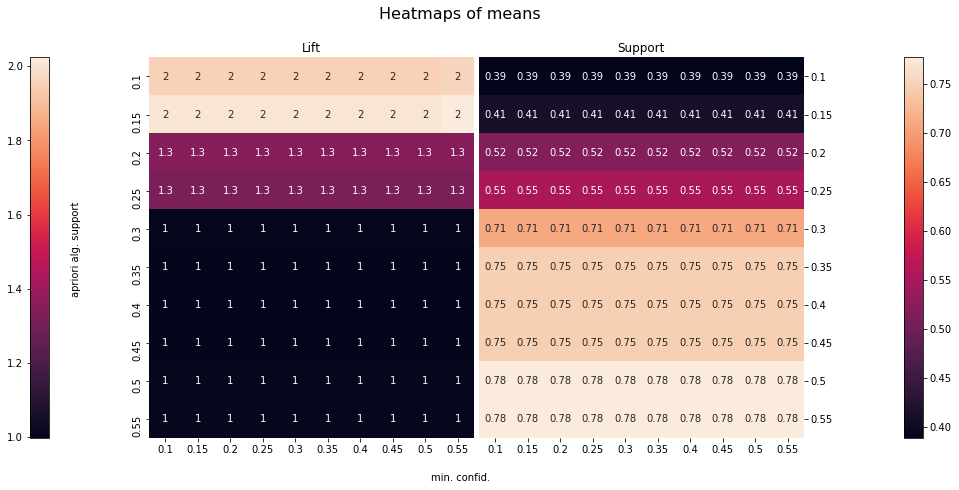

In [19]:
df =  pd.DataFrame(meanOfMetricValues['lift'])
df2 = pd.DataFrame(meanOfSupports['lift'])

fig, (ax,ax2) = plt.subplots(ncols=2)
fig.set_figheight(7)
fig.set_figwidth(18)
fig.suptitle('Heatmaps of means', fontsize=16)
ax.set_title('Lift')
ax2.set_title('Support')
fig.subplots_adjust(wspace=0.01)
sns.heatmap(df, cmap="rocket", ax=ax, xticklabels=ticks, yticklabels=ticks, cbar=False, annot=True)
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(df2, cmap="rocket", ax=ax2, xticklabels=ticks, yticklabels=ticks, cbar=False, annot=True)
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.2)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
fig.text(0.5, 0.04, "min. confid.", ha='center')
fig.text(0.2, 0.5, 'apriori alg. support', va='center', rotation='vertical')
plt.show()

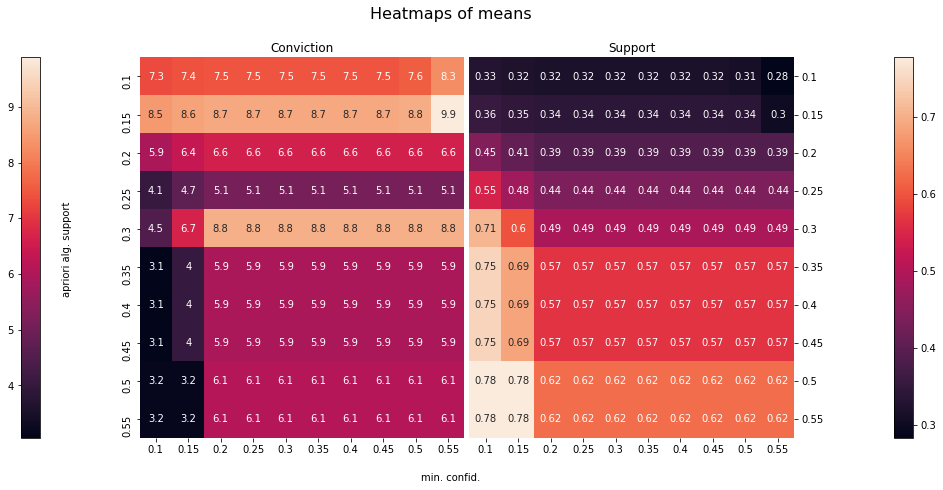

In [20]:
df =  pd.DataFrame(meanOfMetricValues['conviction'])
df2 = pd.DataFrame(meanOfSupports['conviction'])

fig, (ax,ax2) = plt.subplots(ncols=2)
fig.set_figheight(7)
fig.set_figwidth(18)
fig.suptitle('Heatmaps of means', fontsize=16)
ax.set_title('Conviction')
ax2.set_title('Support')
fig.subplots_adjust(wspace=0.01)
sns.heatmap(df, cmap="rocket", ax=ax, xticklabels=ticks, yticklabels=ticks, cbar=False, annot=True)
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.2)
sns.heatmap(df2, cmap="rocket", ax=ax2, xticklabels=ticks, yticklabels=ticks, cbar=False, annot=True)
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.2)
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
fig.text(0.5, 0.04, "min. confid.", ha='center')
fig.text(0.2, 0.5, 'apriori alg. support', va='center', rotation='vertical')
plt.show()

# Interpretace výsledků
Několika opakovanými generováními jsem zjistil, že min. hodnota při generování pravidel (osa X) je maximálně kolem 0.6 (záleží na metrice), jinak algoritmus vygeneruje žádná pravidla. Minimální podpora při apriori algoritmu (osa Y) je také přibližně u 0.6.

Nejzajímavější Heatmapa, která zobrazuje více zkreslený prostor je heatmapa pro metriku Confidence. Každý prvek heatmapy je medián Confidence přes množinu vygenerovaných pravidel.

Vždy záleží na usecase, ale je dobrá ručně porovnat různé metriky a podporu.